In [0]:
!pip3 -qq install torch==0.4.1
!pip install -qq bokeh==0.13.0
!pip install -qq gensim==3.6.0

tcmalloc: large alloc 1073750016 bytes == 0x5a1e4000 @  0x7f05aeb612a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети, часть 2

## POS Tagging

Мы уже посмотрели на применение рекуррентных сетей для классификации.

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg =x250)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Перейдем к ещё одному варианту - sequence labeling (последняя картинка).

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [0]:
import nltk
from sklearn.cross_validation import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения:

In [0]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [0]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [0]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'PRT', 'VERB', 'CONJ', '.', 'ADV', 'X', 'ADP', 'PRON', 'NOUN', 'ADJ', 'DET', 'NUM'}


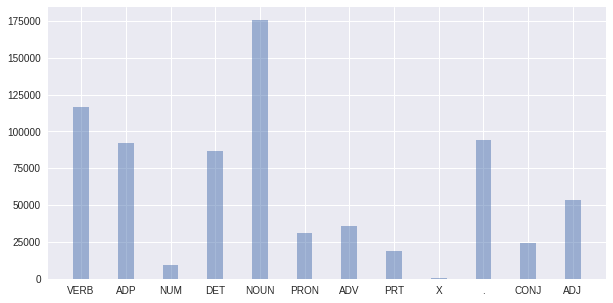

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png =x150)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [0]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [0]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [0]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Делаемся рекуррентнее

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png =x400)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [0]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind.get(tag, 0) for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [0]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [0]:
def iterate_test_batches(data, batch_size):
    X = [[word for word, _ in sample] for sample in data]
    y = [[tag for _, tag in sample] for sample in data]
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = []
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch.append(X[sample_ind])
            y_batch[:len(y[sample_ind]), batch_ind] = [tag2ind.get(tag, 0) for tag in y[sample_ind]]
            
        yield X_batch, y_batch

In [0]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))  # (max_sent_len, batch_size)

# X_batch, y_batch

**Задание** Реализуйте `LSTMTagger`:

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self._embed = nn.Embedding(vocab_size, word_emb_dim)
        self._dropout = nn.Dropout(0.3)
        self._lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        self._out_layer = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        outputs = self._embed(inputs)
        outputs = self._dropout(outputs)
        outputs, _ = self._lstm(outputs)
        outputs = self._out_layer(outputs)
        return outputs

**Задание** Научитесь считать accuracy (а заодно проверьте, что модель работает)

In [0]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

preds = torch.argmax(logits, dim=2)
mask = 1 - preds.eq(0)
acc = torch.sum((preds == y_batch) * mask).item() / (y_batch.shape[0] * y_batch.shape[1])
acc

0.046875

**Задание** Вставьте эти вычисление в функцию:

In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None, pass_val_as_words=False):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    batch_iterator = iterate_batches
    if not is_train and pass_val_as_words:
        batch_iterator = iterate_test_batches
    
    with torch.autograd.set_grad_enabled(is_train):
#         with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(batch_iterator(data, batch_size)):
                if is_train or not pass_val_as_words:
                    X_batch = LongTensor(X_batch)
                y_batch = LongTensor(y_batch)
                logits = model(X_batch)
                loss = criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                logits = logits.view(-1, logits.shape[-1])
                preds = torch.argmax(logits, dim=1)
                mask = 1 - preds.eq(0) # to exclude padding
#                 print(preds.shape, y_batch.shape)
                y_batch = y_batch.view(-1)
                cur_correct_count, cur_sum_count = torch.sum((preds == y_batch) * mask).item(), len(preds)
 
                correct_count += cur_correct_count
                sum_count += cur_sum_count
               
#                 progress_bar.update()
#                 progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
#                     name, loss.item(), cur_correct_count / cur_sum_count)
#                 )
                
#             progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
#                 name, epoch_loss / batches_count, correct_count / sum_count)
#             )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None, pass_val_as_words=False):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        print(name_prefix + 'Train: Loss = {:.5f}, Accuracy = {:.2%}'.format(train_loss, train_acc))
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:', pass_val_as_words=pass_val_as_words)
            print(name_prefix + 'Val: Loss = {:.5f}, Accuracy = {:.2%}'.format(val_loss, val_acc))

In [0]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=64)

[1 / 50] Train: Loss = 0.65300, Accuracy = 24.70%
[1 / 50] Val: Loss = 0.32309, Accuracy = 28.10%
[2 / 50] Train: Loss = 0.30187, Accuracy = 28.39%
[2 / 50] Val: Loss = 0.22306, Accuracy = 28.31%
[3 / 50] Train: Loss = 0.22344, Accuracy = 28.99%
[3 / 50] Val: Loss = 0.17951, Accuracy = 29.56%
[4 / 50] Train: Loss = 0.18032, Accuracy = 29.48%
[4 / 50] Val: Loss = 0.15328, Accuracy = 29.29%
[5 / 50] Train: Loss = 0.15172, Accuracy = 29.64%
[5 / 50] Val: Loss = 0.14095, Accuracy = 29.69%
[6 / 50] Train: Loss = 0.13032, Accuracy = 30.10%
[6 / 50] Val: Loss = 0.12926, Accuracy = 29.72%
[7 / 50] Train: Loss = 0.11464, Accuracy = 30.24%
[7 / 50] Val: Loss = 0.12879, Accuracy = 30.32%
[8 / 50] Train: Loss = 0.10196, Accuracy = 30.30%
[8 / 50] Val: Loss = 0.12061, Accuracy = 29.26%
[9 / 50] Train: Loss = 0.09152, Accuracy = 30.35%
[9 / 50] Val: Loss = 0.11648, Accuracy = 30.15%
[10 / 50] Train: Loss = 0.08308, Accuracy = 30.55%
[10 / 50] Val: Loss = 0.11290, Accuracy = 29.85%
[11 / 50] Train: L

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте

In [0]:
model.eval()

correct_count = 0
sum_count = 0
for X_batch_test, y_batch_test in iterate_batches((X_test, y_test), 64):
    X_batch_test, y_batch_test = torch.cuda.LongTensor(X_batch_test), torch.cuda.LongTensor(y_batch_test)
    logits = model(X_batch_test)
    preds = torch.argmax(logits, dim=2)
    mask = 1 - preds.eq(0)
    correct_count += torch.sum((preds == y_batch_test) * mask).item()
    sum_count += len(preds.view(-1))
print("Accuracy of LSTMT tagger: {:.2%}".format( correct_count / sum_count ) )

Accuracy of LSTMT tagger: 30.78%


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png =x450)  
from [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)

**Задание** Добавьте Bidirectional LSTM.

In [0]:
model.eval()

correct_count = 0
sum_count = 0
for X_batch_test, y_batch_test in iterate_batches((X_test, y_test), 64):
    X_batch_test, y_batch_test = torch.cuda.LongTensor(X_batch_test), torch.cuda.LongTensor(y_batch_test)
    logits = model(X_batch_test)
    preds = torch.argmax(logits, dim=2)
    mask = 1 - preds.eq(0)
    correct_count += torch.sum((preds == y_batch_test) * mask).item()
    sum_count += len(preds.view(-1))
print("Accuracy of BiLSTMT tagger: {:.2%}".format( correct_count / sum_count ) )

Accuracy of BiLSTMT tagger: 31.02%


(И это только благодаря дропауту( )

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [0]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


Построим подматрицу для слов из нашей тренировочной выборки:

In [0]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [0]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings))
        self._emb_dim = self._emb.weight.shape[-1]
        self._dropout = nn.Dropout(0.3)
        self._lstm = nn.LSTM(self._emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        self._out_layer = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        if self.training:
            outputs = self._emb(inputs)
        else:
            batch_size = len(inputs)
            max_sent_len = max(len(sent) for sent in inputs)
            outputs = self._emb.weight.new_zeros((max_sent_len, batch_size, self._emb_dim))
            for i, sent in enumerate(inputs):
                for j, word in enumerate(sent):
                    if word in w2v_model.vocab:
                        outputs[j, i] = torch.from_numpy(w2v_model.get_vector(word))
        outputs = self._dropout(outputs)
        outputs, _ = self._lstm(outputs)
        outputs = self._out_layer(outputs)
        return outputs

In [0]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=val_data, val_batch_size=64, pass_val_as_words=True)

[1 / 50] Train: Loss = 0.70392, Accuracy = 24.39%
[1 / 50] Val: Loss = 51.40134, Accuracy = 26.93%
[2 / 50] Train: Loss = 0.32310, Accuracy = 28.26%
[2 / 50] Val: Loss = 42.13447, Accuracy = 27.70%
[3 / 50] Train: Loss = 0.24809, Accuracy = 29.01%
[3 / 50] Val: Loss = 39.17144, Accuracy = 27.93%
[4 / 50] Train: Loss = 0.20956, Accuracy = 29.26%
[4 / 50] Val: Loss = 38.50707, Accuracy = 28.48%
[5 / 50] Train: Loss = 0.18703, Accuracy = 29.29%
[5 / 50] Val: Loss = 38.56161, Accuracy = 28.11%
[6 / 50] Train: Loss = 0.17251, Accuracy = 29.48%
[6 / 50] Val: Loss = 37.84654, Accuracy = 28.59%
[7 / 50] Train: Loss = 0.16135, Accuracy = 29.65%
[7 / 50] Val: Loss = 37.73847, Accuracy = 28.96%
[8 / 50] Train: Loss = 0.15208, Accuracy = 29.68%
[8 / 50] Val: Loss = 38.19388, Accuracy = 28.44%
[9 / 50] Train: Loss = 0.14586, Accuracy = 29.99%
[9 / 50] Val: Loss = 38.26041, Accuracy = 28.91%
[10 / 50] Train: Loss = 0.13977, Accuracy = 29.89%
[10 / 50] Val: Loss = 37.69886, Accuracy = 28.71%
[11 / 50

KeyboardInterrupt: ignored

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

In [0]:
model.eval()

correct_count = 0
sum_count = 0
for X_batch_test, y_batch_test in iterate_test_batches(test_data, 64):
    y_batch_test = torch.cuda.LongTensor(y_batch_test)
    logits = model(X_batch_test)
    preds = torch.argmax(logits, dim=2)
    mask = 1 - preds.eq(0)
    correct_count += torch.sum((preds == y_batch_test) * mask).item()
    sum_count += len(preds.view(-1))
print("Accuracy of LSTMTaggerWithPretrainedEmbs: {:.2%}".format( correct_count / sum_count ) )

Accuracy of LSTMTaggerWithPretrainedEmbs: 29.27%


### Дообучение предобученных векторов

**Задание** Почему бы не попробовать дообучать вектора? Для этого нужно просто заменить флаг `freeze=False` в методе `from_pretrained`. Попробуйте.

In [0]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), freeze=False )
        self._emb_dim = self._emb.weight.shape[-1]
        self._dropout = nn.Dropout(0.3)
        self._lstm = nn.LSTM(self._emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        self._out_layer = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        if self.training:
            outputs = self._emb(inputs)
        else:
            batch_size = len(inputs)
            max_sent_len = max(len(sent) for sent in inputs)
            outputs = self._emb.weight.new_zeros((max_sent_len, batch_size, self._emb_dim))
            for i, sent in enumerate(inputs):
                for j, word in enumerate(sent):
                    if word in w2v_model.vocab:
                        outputs[j, i] = torch.from_numpy(w2v_model.get_vector(word))
        outputs = self._dropout(outputs)
        outputs, _ = self._lstm(outputs)
        outputs = self._out_layer(outputs)
        return outputs

In [0]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=val_data, val_batch_size=512, pass_val_as_words=True)

[1 / 50] Train: Loss = 0.47417, Accuracy = 26.74%
[1 / 50] Val: Loss = 8.60263, Accuracy = 15.67%
[2 / 50] Train: Loss = 0.12094, Accuracy = 30.05%
[2 / 50] Val: Loss = 8.79219, Accuracy = 16.46%
[3 / 50] Train: Loss = 0.08494, Accuracy = 30.49%
[3 / 50] Val: Loss = 9.03400, Accuracy = 16.04%
[4 / 50] Train: Loss = 0.06644, Accuracy = 30.64%
[4 / 50] Val: Loss = 8.82678, Accuracy = 17.63%
[5 / 50] Train: Loss = 0.05491, Accuracy = 30.78%
[5 / 50] Val: Loss = 8.84642, Accuracy = 16.50%
[6 / 50] Train: Loss = 0.04703, Accuracy = 30.72%
[6 / 50] Val: Loss = 9.47900, Accuracy = 16.29%
[7 / 50] Train: Loss = 0.04077, Accuracy = 31.09%
[7 / 50] Val: Loss = 9.93246, Accuracy = 16.78%
[8 / 50] Train: Loss = 0.03686, Accuracy = 31.01%
[8 / 50] Val: Loss = 10.25840, Accuracy = 15.67%
[9 / 50] Train: Loss = 0.03309, Accuracy = 30.76%
[9 / 50] Val: Loss = 10.72721, Accuracy = 15.70%
[10 / 50] Train: Loss = 0.02986, Accuracy = 30.97%
[10 / 50] Val: Loss = 10.66701, Accuracy = 15.72%
[11 / 50] Train

KeyboardInterrupt: ignored

In [0]:
model.eval()

correct_count = 0
sum_count = 0
for X_batch_test, y_batch_test in iterate_test_batches(test_data, 64):
    y_batch_test = torch.cuda.LongTensor(y_batch_test)
    logits = model(X_batch_test)
    preds = torch.argmax(logits, dim=2)
    mask = 1 - preds.eq(0)
    correct_count += torch.sum((preds == y_batch_test) * mask).item()
    sum_count += len(preds.view(-1))
print("Accuracy of LSTMTaggerWithPretrainedEmbs: {:.2%}".format( correct_count / sum_count ) )

Accuracy of LSTMT tagger: 24.82%


**Задание** На самом деле, понятно, почему это плохо - после этого нельзя использовать старые предобученные вектора (которые не попали в трейн). Проверьте, какое качество получается на тесте со старыми векторами.

Чтобы бороться с этим, можно использовать такой прием: на предобученные вектора накладывать $l_2$-регуляризацию, чтобы они не удалялись от исходных векторов, а для слов, эмбеддинги которых мы не знаем, строить случайные вектора и учить их как обычно.

**Задание** Попробуйте реализовать это.

## We need to go deeper

Напомню, на прошлом занятии мы строили LSTM сеть, которая обрабатывала последовательности символов, и предсказывала, к какому языку относится слово. 

LSTM выступал в роли feature extractor'а, работающего с произвольного размера последовательностью символов (ну, почти произвольного - мы ограничивались максимальной длиной слова). Батч для сети имел размерность `(max_word_len, batch_size)`.

Теперь мы опять хотим использовать такую же идею для извлечения признаков из последовательности символов - потому что последовательность символов же должна быть полезной для предсказания части речи, правда?

Сеть должна будет запомнить, например, что `-ly` - это часто про наречие, а `-tion` - про существительное.

![](https://image.ibb.co/kzbh6L/Char-Bi-LSTM.png =x400)

Остальная часть сети при этом будет такой же.

Найдем границу для длины слов:

In [0]:
from collections import Counter 
    
def find_max_len(counter, threshold):
    sum_count = sum(counter.values())
    cum_count = 0
    for i in range(max(counter)):
        cum_count += counter[i]
        if cum_count > sum_count * threshold:
            return i
    return max(counter)

word_len_counter = Counter()
for sent in data:
    for word, _ in sent:
        word_len_counter[len(word)] += 1
    
threshold = 0.99
MAX_WORD_LEN = find_max_len(word_len_counter, threshold)

print('Max word len for {:.0%} of words is {}'.format(threshold, MAX_WORD_LEN))

Построим алфавит:

In [0]:
from string import punctuation

def get_range(first_symb, last_symb):
    return set(chr(c) for c in range(ord(first_symb), ord(last_symb) + 1))

chars = get_range('a', 'z') | get_range('A', 'Z') | get_range('0', '9') | set(punctuation)
char2ind = {c : i + 1 for i, c in enumerate(chars)}
char2ind['<pad>'] = 0

**Задание** Сконвертируйте данные, как в функции выше - только теперь слова должны отобразиться не в один индекс, а в последовательность.

Обрезайте слова по `MAX_WORD_LEN`.

In [0]:
def convert_data(data, char2ind, tag2ind):
    X = [[[char2ind.get(ch, 0) for ch in word[:MAX_WORD_LEN]] for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    return X, y
  
X_train, y_train = convert_data(train_data, char2ind, tag2ind)
X_val, y_val = convert_data(val_data, char2ind, tag2ind)
X_test, y_test = convert_data(test_data, char2ind, tag2ind)

Напишем генератор батчей:

In [0]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start: end]
        
        sent_len = max(len(X[ind]) for ind in batch_indices)
        word_len = max(len(word) for ind in batch_indices for word in X[ind])
            
        X_batch = np.zeros((sent_len, len(batch_indices), word_len))
        y_batch = np.zeros((sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            for word_ind, word in enumerate(X[sample_ind]):
                X_batch[word_ind, batch_ind, :len(word)] = word
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [0]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

**Задание** Реализуйте сеть, которая принимает батч размера `(seq_len, batch_size, word_len)` и возвращает `(seq_len, batch_size, word_emb_dim)`. Это может быть любая функция, которая умеет в последовательности произвольной длины. Мы уже смотрели на сверточные и рекуррентные сети для такой задачи - попробуйте обе.

In [0]:
class CharsEmbedding(nn.Module):
    def __init__(self, vocab_size, char_emb_dim=24, word_emb_dim=100):
        super().__init__()
        self._embs = nn.Embedding(vocab_size, char_emb_dim)
        self._conv = nn.Conv2d(in_channels=1, out_channels=word_emb_dim, kernel_size=(2, char_emb_dim))
#         <create Conv or LSTM encoder>
        
    def forward(self, inputs):
        outputs = self._embs(inputs)
        print(outputs.shape)
        seq_len, batch_size = outputs.shape[:2]
        outputs = outputs.view(seq_len*batch_size, 1, outputs.shape[2], outputs.shape[3])
        print(outputs.shape)
        outputs = self._conv(ouputs)

In [0]:
model = CharsEmbedding(len(char2ind))
X_batch = torch.LongTensor(X_batch)
model(X_batch)

**Задание** Реализуйте теггер с эмбеддингами символьного уровня.

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, char_vocab_size, tagset_size, char_emb_dim=24, 
                 word_emb_dim=128, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        <create it>

    def forward(self, inputs):
        <apply>

In [0]:
model = LSTMTagger(char_vocab_size=len(char2ind), tagset_size=len(tag2ind)).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20, 
    batch_size=24, val_data=(X_val, y_val), val_batch_size=32)

**Задание** Оцените его качество.

In [0]:
_, test_accuracy = do_epoch(model, criterion, (X_test, y_test), batch_size=32)

### Визуализации

**Задание** Посчитайте эмбеддинги символьного уровня (обученные внутри модели перед этим) для 1000 случайных слов из `word2ind`.

In [0]:
embeddings, index2word = <calc me>

In [0]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], token=token)
    

visualize_embeddings(embeddings, index2word)

**Задание** Посчитайте эмбеддинги для всех слов из трейна и для нескольких случайных слов из теста, которые не встречаются в трейне, найдите их ближайших соседей по их эмбеддигам символьного уровня.

### Словные эмбеддинги

**Задание** Только символьных эмбеддингов может быть недостаточно. Верните ещё словные эмбеддинги. Слова стоит приводить к нижнему регистру - признаки, связанные с регистром должны ухватываться символьный LSTM.

Эти эмбеддинги можно просто сконкатенировать, можно складывать, а можно использовать гейт (как в LSTM). Например, по эмбеддингу слова предсказывать $o = \sigma(w)$ - насколько он хорош и сочетать в такой пропорции с символьным эмбеддингом: $o \odot w + (1 - o) \odot \tilde w$, где $\tilde w$ - эмбеддинг слова, полученный по символьному уровню. Проверьте разные варианты.

### Связь словных эмбеддингов и эмбеддингов символьного уровня
В словных эмбеддингах мы строим отображение из слова в индекс. В итоге входной батч достаточно небольшой - это хорошо для обучения (быстрее передача на видеокарту). С символьными эмбеддингами беда - но это можно исправить.

Давайте предпосчитаем для каждого слова в `word2ind` его последовательность индексов символов. Получится матрица. Эту матрицу можно вместе с моделью перенести на видеокарту. Тогда нужен будет батч из индексов слов - по нему можно сделать лукап (с помощью `F.embedding`) в матрице и получить трехмерную матрицу с символами.

Преимущество - по одному батчу можно получить сразу и эмбеддинги слов, и эмбеддинги символьного уровня. Это удобно и энергоэффективно.

Другая идея - после того, как мы обучили модель, можно предпосчитать эмбеддинги слов символьного уровня - лукап в таблице эмбеддингов гораздо проще, чем сверточная или рекуррентная сеть над символами. Таким образом, например, получаются эмбеддинги в [FastText](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) - они также исходно считаются на символьном (N-граммном) уровне.

## Encoder-decoder

Можно усложнить модель - добавить еще один рекуррентный слой. Первый слой будет служить энкодером последовательности, второй, более легкий - декодировать последовательность. Декодировать - значит, на вход он должен принимать как состояние для данного токена из энкодера, так и предыдущий предсказанный тег.

**Задание** Рискните реализовать это.

# Сдача

[Опрос](https://goo.gl/forms/R6UqcESWIjtVSA6J3)